<a href="https://colab.research.google.com/github/Abdallahalii12/Deep-learningProject/blob/main/Final_version_Image_fault_detection__(2)project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image fault detection of casting products using CNN

# Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# importing our libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# train and test dir

In [ ]:
train_dir = '/content/drive/MyDrive/Deep learning project/archive (1)/casting_data/casting_data/train'

test_dir = '/content/drive/MyDrive/Deep learning project/archive (1)/casting_data/casting_data/test'

# image and batch sizes

In [ ]:
# Configuration
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 16

# function for generating the data

In [ ]:
# Data generators
def create_data_generators(preprocessing_function):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator


# ploting the training history

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


# evaluating our models

In [ ]:
def evaluate_model(model, test_generator):
    # Predict on Test Data
    y_true = test_generator.classes
    y_probs = model.predict(test_generator)
    y_pred = np.argmax(y_probs, axis=1)

    # Classification Report
    print("Classification Report:")
    report = classification_report(y_true, y_pred, target_names=['Defective', 'OK'])
    print(report)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Defective', 'OK'], yticklabels=['Defective', 'OK'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return {
        'accuracy': np.mean(y_pred == y_true),
        'auc': roc_auc,
        'report': report
    }

# callbacks and earlystopping to avoid overfitting

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [ ]:
def create_pretrained_model(base_model, input_shape=IMAGE_SIZE + (3,), num_classes=2):
    base = base_model(weights="imagenet", include_top=False, input_shape=input_shape)

    # Freeze most layers
    for layer in base.layers[:-10]:
        layer.trainable = False

    model = tf.keras.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


# storing the results and comparing our models


Training DenseNet
Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


332/332 ━━━━━━━━━━━━━━━━━━━━ 166s 326ms/step - accuracy: 0.7059 - loss: 0.6212 - val_accuracy: 0.9510 - val_loss: 0.1448 - learning_rate: 1.0000e-04
Epoch 2/7
332/332 ━━━━━━━━━━━━━━━━━━━━ 122s 209ms/step - accuracy: 0.9239 - loss: 0.1908 - val_accuracy: 0.9834 - val_loss: 0.0688 - learning_rate: 1.0000e-04
Epoch 3/7
332/332 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - accuracy: 0.9594 - loss: 0.1130 - val_accuracy: 0.9834 - val_loss: 0.0508 - learning_rate: 1.0000e-04
Epoch 4/7
332/332 ━━━━━━━━━━━━━━━━━━━━ 80s 203ms/step - accuracy: 0.9706 - loss: 0.0901 - val_accuracy: 0.9910 - val_loss: 0.0376 - learning_rate: 1.0000e-04
Epoch 5/7
332/332 ━━━━━━━━━━━━━━━━━━━━ 77s 227ms/step - accuracy: 0.9717 - loss: 0.0837 - val_accuracy: 0.9879 - val_loss: 0.0477 - learning_rate: 1.0000e-04

Evaluating DenseNet:


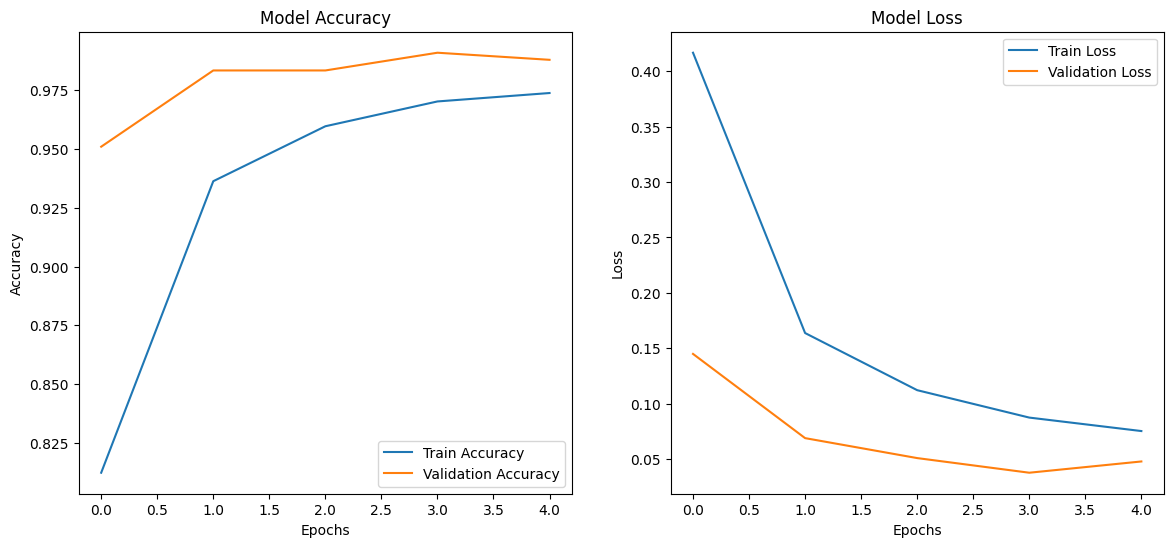

45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step
Classification Report:
              precision    recall  f1-score   support

   Defective       0.99      0.98      0.99       453
          OK       0.96      0.99      0.98       262

    accuracy                           0.98       715
   macro avg       0.98      0.98      0.98       715
weighted avg       0.98      0.98      0.98       715



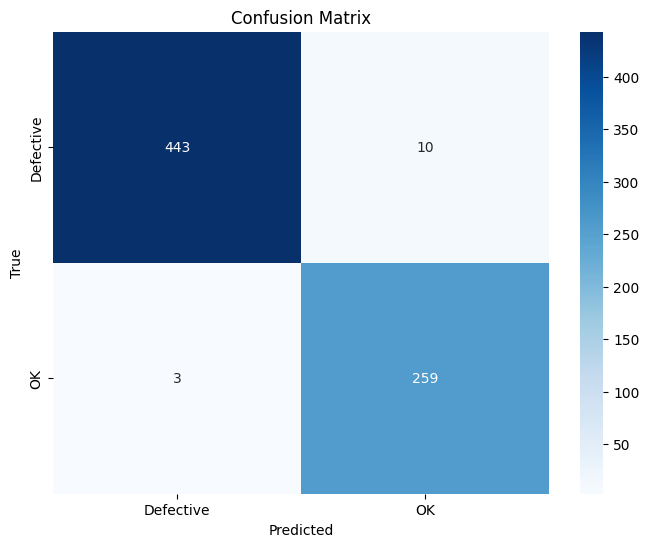

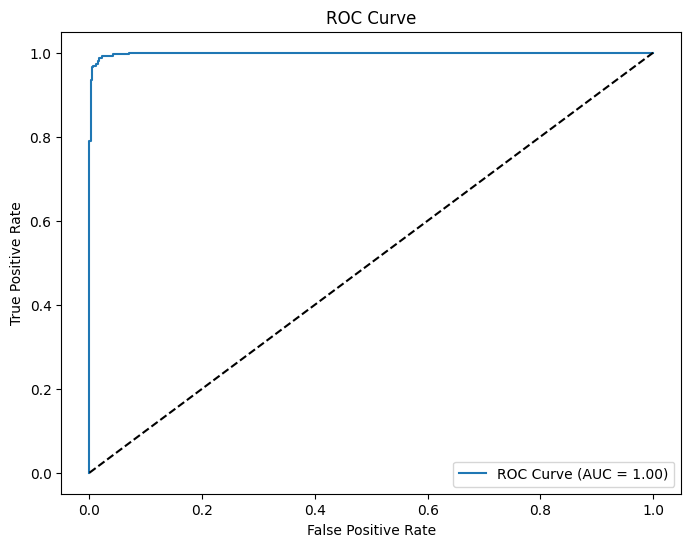


Training Xception
Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


332/332 ━━━━━━━━━━━━━━━━━━━━ 131s 250ms/step - accuracy: 0.8274 - loss: 0.3499 - val_accuracy: 0.9819 - val_loss: 0.0647 - learning_rate: 1.0000e-04
Epoch 2/7
332/332 ━━━━━━━━━━━━━━━━━━━━ 87s 211ms/step - accuracy: 0.9697 - loss: 0.0932 - val_accuracy: 0.9872 - val_loss: 0.0488 - learning_rate: 1.0000e-04
Epoch 3/7
332/332 ━━━━━━━━━━━━━━━━━━━━ 81s 209ms/step - accuracy: 0.9712 - loss: 0.0751 - val_accuracy: 0.9419 - val_loss: 0.1496 - learning_rate: 1.0000e-04
Epoch 4/7
332/332 ━━━━━━━━━━━━━━━━━━━━ 70s 207ms/step - accuracy: 0.9707 - loss: 0.0740 - val_accuracy: 0.9163 - val_loss: 0.2112 - learning_rate: 1.0000e-04
Epoch 5/7
332/332 ━━━━━━━━━━━━━━━━━━━━ 78s 232ms/step - accuracy: 0.9754 - loss: 0.0600 - val_accuracy: 0.9336 - val_loss: 0.1955 - learning_rate: 1.0000e-04

Evaluating Xception:


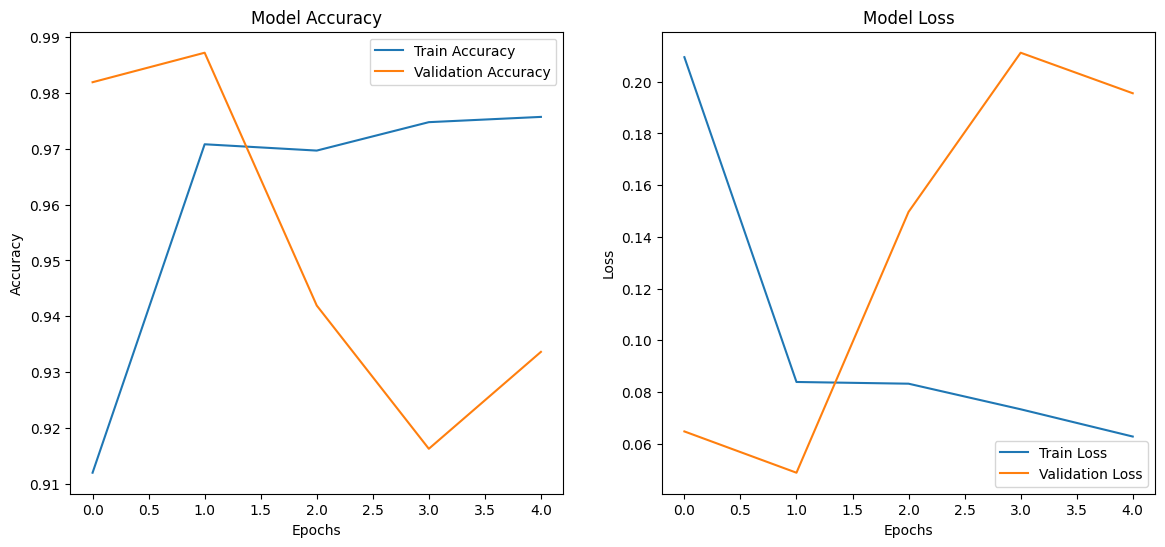

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step
Classification Report:
              precision    recall  f1-score   support

   Defective       1.00      0.99      0.99       453
          OK       0.99      0.99      0.99       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



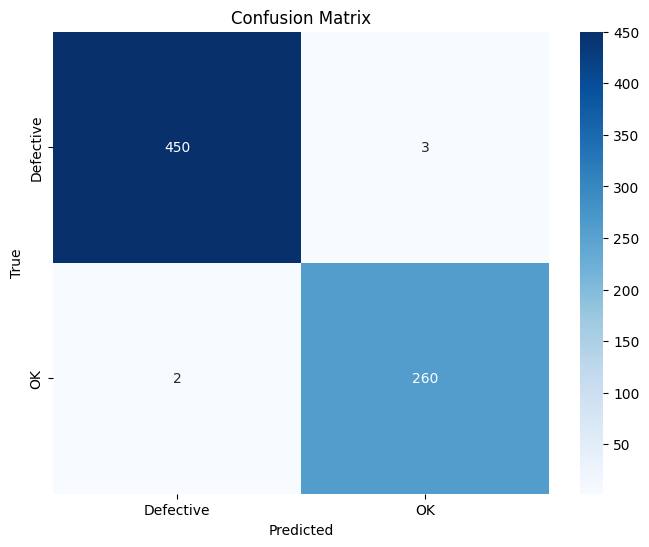

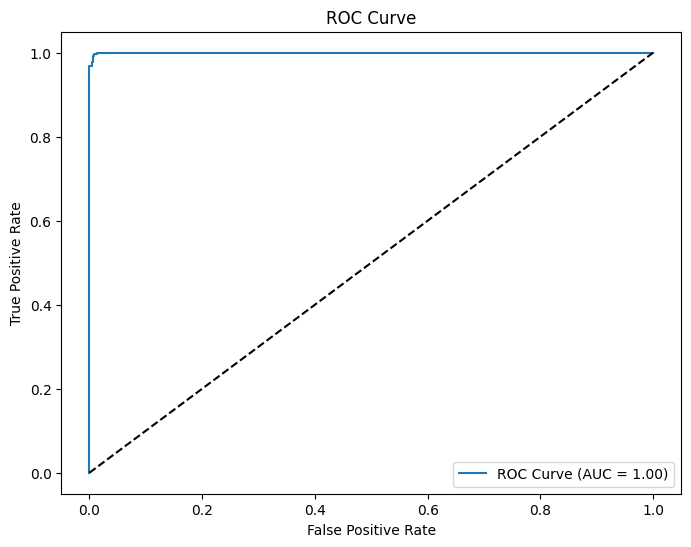

In [ ]:
# Store results for comparison
model_results = {}

# Define models to train
models_to_train = {
    'DenseNet': (create_pretrained_model(DenseNet121), densenet_preprocess),
    'Xception': (create_pretrained_model(Xception), xception_preprocess)
}

# Train and evaluate each model
for model_name, (model, preprocess_func) in models_to_train.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    # Create data generators with appropriate preprocessing
    train_generator, validation_generator, test_generator = create_data_generators(preprocess_func)

    # Calculate class weights
    total_samples = train_generator.samples
    n_classes = 2
    class_weights = {
        0: total_samples / (n_classes * np.sum(train_generator.classes == 0)),
        1: total_samples / (n_classes * np.sum(train_generator.classes == 1))
    }

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    steps_per_epoch = np.ceil(train_generator.samples / BATCH_SIZE).astype(int)
    validation_steps = np.ceil(validation_generator.samples / BATCH_SIZE).astype(int)

    # Train model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=7,
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate model
    print(f"\nEvaluating {model_name}:")
    plot_training_history(history)
    results = evaluate_model(model, test_generator)

    # Store results
    model_results[model_name] = {
        'history': history.history,
        'evaluation': results
    }



# Compare model performances
print("\nModel Comparison:")
print("="*50)
for model_name, results in model_results.items():
    print(f"\n{model_name}:")
    print(f"Final Accuracy: {results['evaluation']['accuracy']:.4f}")
    print(f"AUC Score: {results['evaluation']['auc']:.4f}")
    print("-"*30)

# creating our resnet model

In [ ]:
# ResNet50 Model Definition
class BottleneckBlock(layers.Layer):
    def __init__(self, filters, strides=1, downsample=False):
        super(BottleneckBlock, self).__init__()
        self.downsample = downsample
        self.conv1 = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, (3, 3), strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(filters * 4, (1, 1), strides=1, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.relu = layers.ReLU()

        if self.downsample:
            self.downsample_conv = layers.Conv2D(filters * 4, (1, 1), strides=strides, padding='same')
            self.downsample_bn = layers.BatchNormalization()

    def call(self, inputs, training=False):
        shortcut = inputs
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x, training=training)

        if self.downsample:
            shortcut = self.downsample_conv(inputs)
            shortcut = self.downsample_bn(shortcut, training=training)

        x += shortcut
        x = self.relu(x)
        return x

class ResNet50(Model):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()
        self.conv1 = layers.Conv2D(64, (7, 7), strides=2, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.max_pool = layers.MaxPooling2D((3, 3), strides=2, padding='same')

        self.stage2 = self._make_stage(64, 3)
        self.stage3 = self._make_stage(128, 4, strides=2)
        self.stage4 = self._make_stage(256, 6, strides=2)
        self.stage5 = self._make_stage(512, 3, strides=2)

        self.global_pool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def _make_stage(self, filters, blocks, strides=1):
        res_blocks = []
        res_blocks.append(BottleneckBlock(filters, strides, downsample=True))
        for _ in range(1, blocks):
            res_blocks.append(BottleneckBlock(filters))
        return tf.keras.Sequential(res_blocks)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.stage2(x, training=training)
        x = self.stage3(x, training=training)
        x = self.stage4(x, training=training)
        x = self.stage5(x, training=training)

        x = self.global_pool(x)
        x = self.fc(x)
        return x


# a function to compare the models

In [ ]:

# Function to compare models
def compare_models(models_dict, train_generator, validation_generator, test_generator, epochs=5):
    """
    Train and compare multiple models

    Args:
        models_dict: Dictionary of model names and their instances
        train_generator: Training data generator
        validation_generator: Validation data generator
        test_generator: Test data generator
        epochs: Number of epochs to train
    """
    results = {}

    for model_name, model in models_dict.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name}")
        print(f"{'='*50}")

        # Calculate class weights
        total_samples = train_generator.samples
        n_classes = 2
        class_weights = {
            0: total_samples / (n_classes * np.sum(train_generator.classes == 0)),
            1: total_samples / (n_classes * np.sum(train_generator.classes == 1))
        }

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=5, restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6
            )
        ]

        steps_per_epoch=np.ceil(train_generator.samples / train_generator.batch_size).astype(int),
        validation_steps=np.ceil(validation_generator.samples / validation_generator.batch_size).astype(int),
        # Train model
        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            class_weight=class_weights,
            callbacks=callbacks
        )

        # Evaluate model
        print(f"\nEvaluating {model_name}:")
        plot_training_history(history)
        evaluation_results = evaluate_model(model, test_generator)

        # Store results
        results[model_name] = {
            'history': history.history,
            'evaluation': evaluation_results
        }

    return results



#comparing the models and plotting the results

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.

Training ResNet50
Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 168s 278ms/step - accuracy: 0.6577 - loss: 0.7240 - val_accuracy: 0.6433 - val_loss: 0.7087 - learning_rate: 1.0000e-04
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 87s 239ms/step - accuracy: 0.7795 - loss: 0.5016 - val_accuracy: 0.5882 - val_loss: 1.5454 - learning_rate: 1.0000e-04
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 71s 211ms/step - accuracy: 0.8339 - loss: 0.4016 - val_accuracy: 0.6983 - val_loss: 0.7729 - learning_rate: 1.0000e-04
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 82s 211ms/step - accuracy: 0.8773 - loss: 0.3021 - val_accuracy: 0.9110 - val_loss: 0.2985 - learning_rate: 1.0000e-04
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 84s 217ms/step - accuracy: 0.9184 - loss: 0.2097 - val_accuracy: 0.9186 - val_loss: 0.2822 - learning_rate: 1.0000e-04

Evaluating ResNet50:


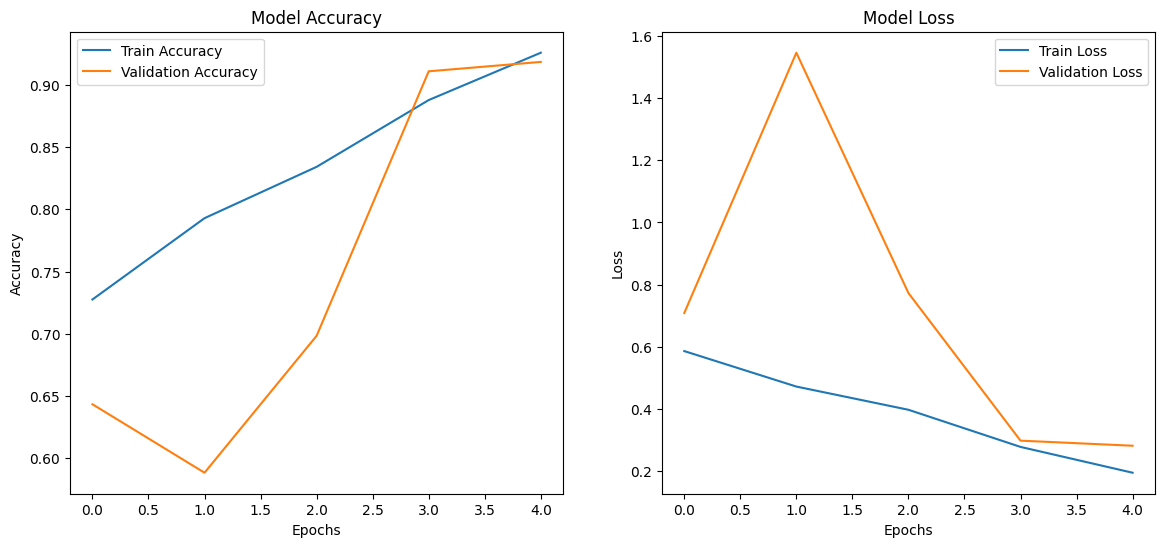

45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step
Classification Report:
              precision    recall  f1-score   support

   Defective       0.94      0.92      0.93       453
          OK       0.86      0.90      0.88       262

    accuracy                           0.91       715
   macro avg       0.90      0.91      0.91       715
weighted avg       0.91      0.91      0.91       715



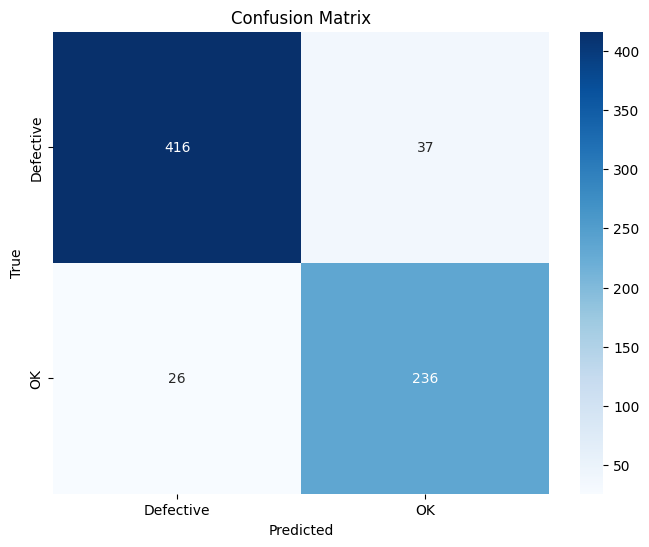

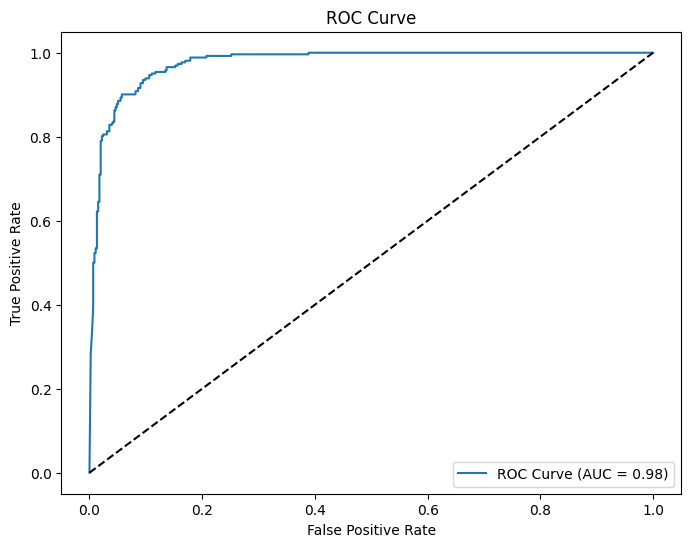


Training DenseNet
Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 104s 251ms/step - accuracy: 0.6247 - loss: 0.7439 - val_accuracy: 0.8816 - val_loss: 0.3157 - learning_rate: 1.0000e-04
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 119s 201ms/step - accuracy: 0.8528 - loss: 0.3407 - val_accuracy: 0.9057 - val_loss: 0.2118 - learning_rate: 1.0000e-04
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 81s 198ms/step - accuracy: 0.9030 - loss: 0.2298 - val_accuracy: 0.9404 - val_loss: 0.1519 - learning_rate: 1.0000e-04
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 89s 220ms/step - accuracy: 0.9243 - loss: 0.1860 - val_accuracy: 0.9668 - val_loss: 0.1033 - learning_rate: 1.0000e-04
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.9346 - loss: 0.1697 - val_accuracy: 0.9585 - val_loss: 0.1234 - learning_rate: 1.0000e-04

Evaluating DenseNet:


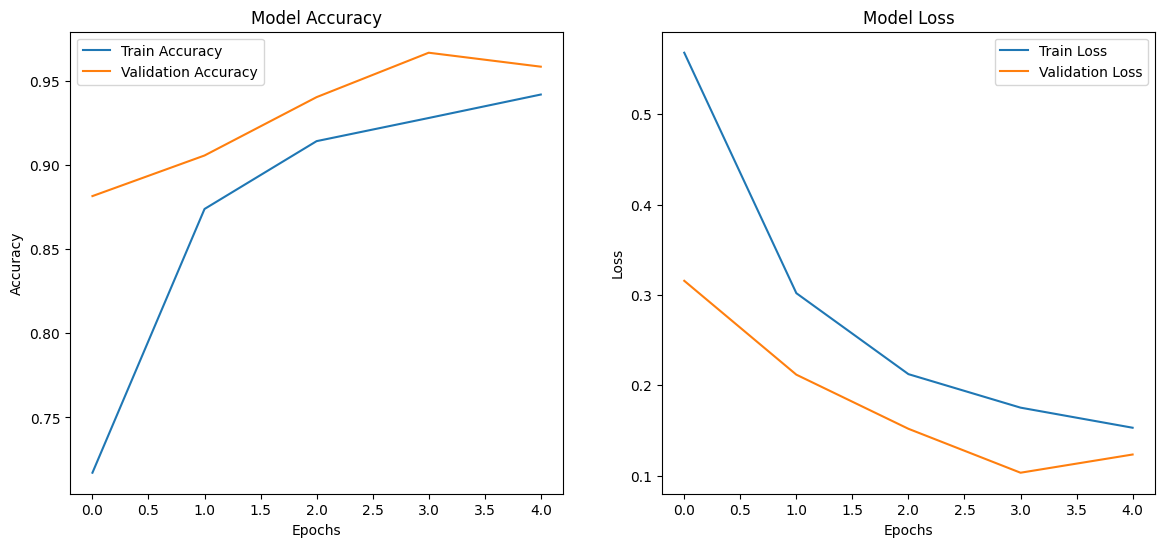

45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step
Classification Report:
              precision    recall  f1-score   support

   Defective       1.00      0.90      0.95       453
          OK       0.85      1.00      0.92       262

    accuracy                           0.94       715
   macro avg       0.93      0.95      0.93       715
weighted avg       0.95      0.94      0.94       715



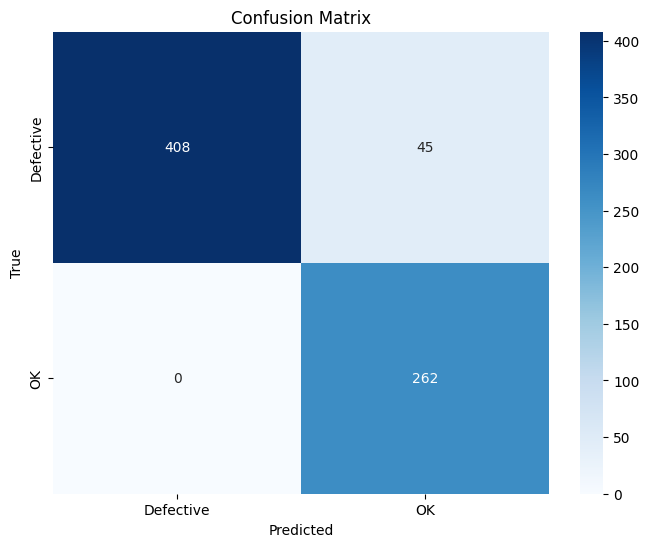

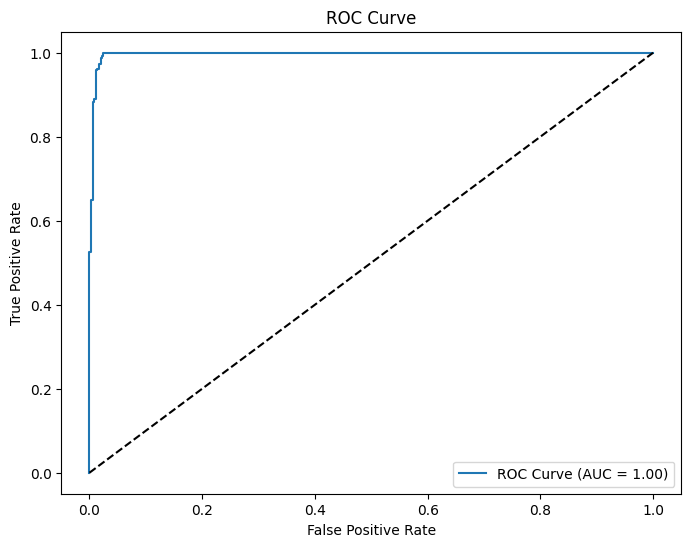


Training Xception
Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 83s 223ms/step - accuracy: 0.6383 - loss: 0.6087 - val_accuracy: 0.5520 - val_loss: 1.0426 - learning_rate: 1.0000e-04
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 72s 205ms/step - accuracy: 0.7879 - loss: 0.4566 - val_accuracy: 0.7888 - val_loss: 0.4894 - learning_rate: 1.0000e-04
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 67s 200ms/step - accuracy: 0.7992 - loss: 0.4340 - val_accuracy: 0.7632 - val_loss: 0.5827 - learning_rate: 1.0000e-04
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 89s 223ms/step - accuracy: 0.8191 - loss: 0.3990 - val_accuracy: 0.8454 - val_loss: 0.3470 - learning_rate: 1.0000e-04
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 76s 204ms/step - accuracy: 0.8221 - loss: 0.3833 - val_accuracy: 0.7934 - val_loss: 0.4457 - learning_rate: 1.0000e-04

Evaluating Xception:


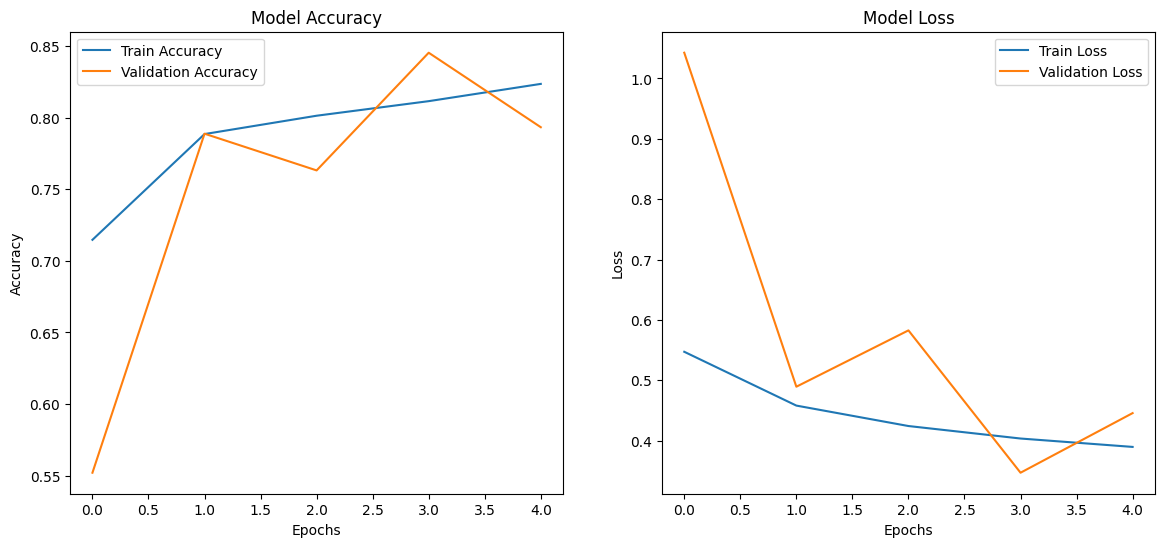

45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step
Classification Report:
              precision    recall  f1-score   support

   Defective       0.87      0.89      0.88       453
          OK       0.81      0.77      0.79       262

    accuracy                           0.85       715
   macro avg       0.84      0.83      0.84       715
weighted avg       0.85      0.85      0.85       715



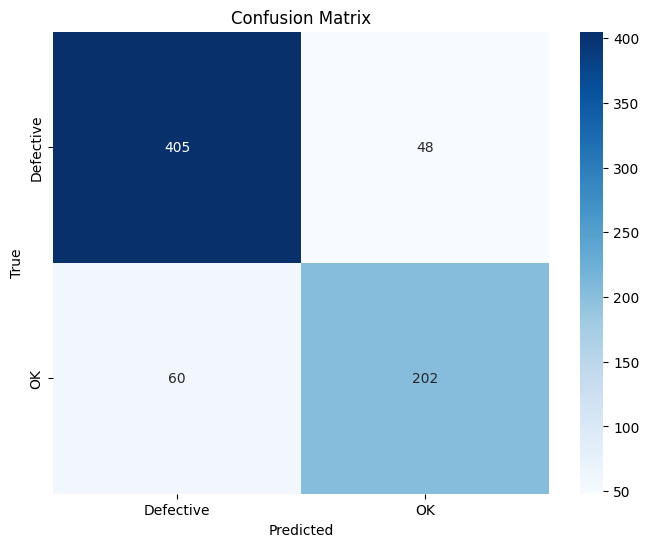

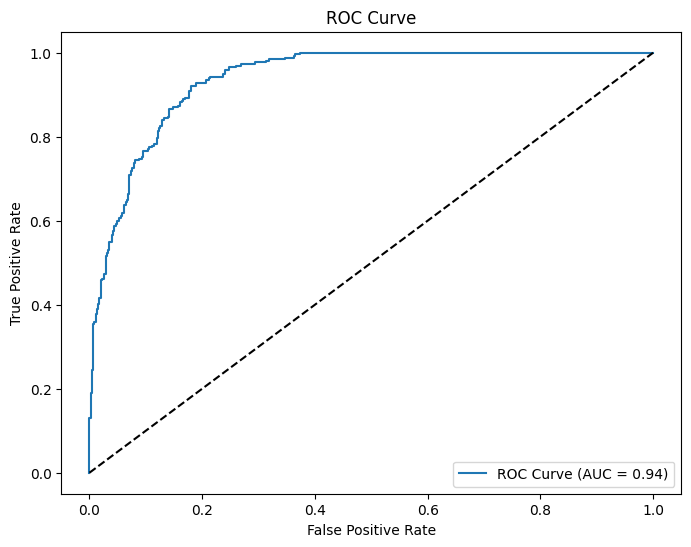

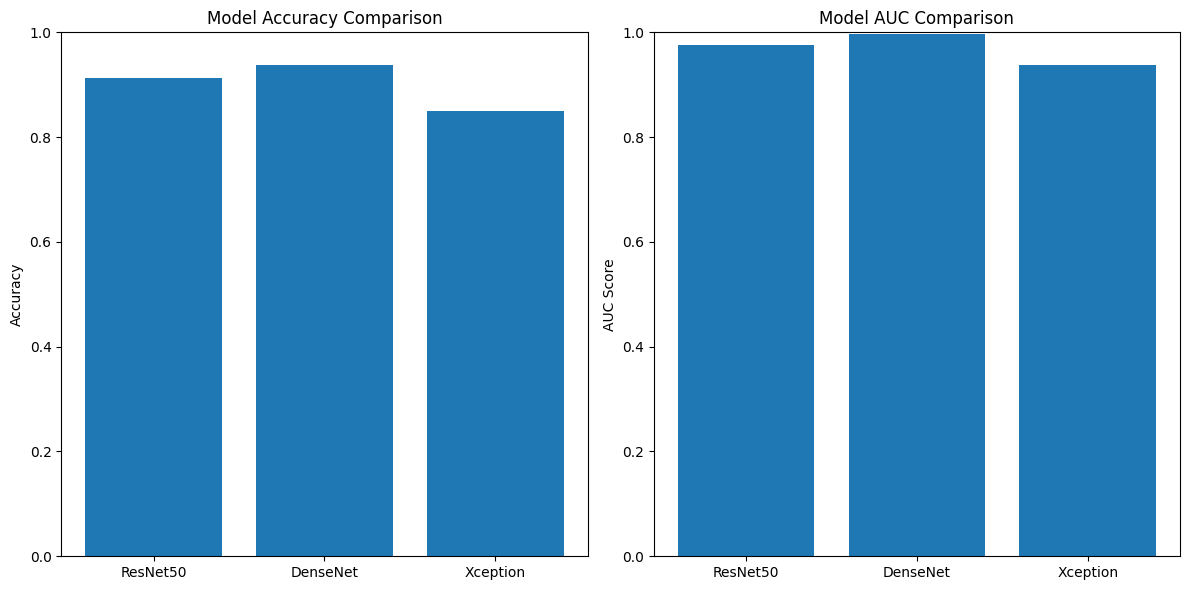


Detailed Model Comparison:

ResNet50:
Final Accuracy: 0.9119
AUC Score: 0.9756
------------------------------

DenseNet:
Final Accuracy: 0.9371
AUC Score: 0.9965
------------------------------

Xception:
Final Accuracy: 0.8490
AUC Score: 0.9375
------------------------------


In [ ]:
def plot_models_comparison(results):
    """Plot comparison of model performances"""
    model_names = list(results.keys())
    accuracies = [results[model]['evaluation']['accuracy'] for model in model_names]
    auc_scores = [results[model]['evaluation']['auc'] for model in model_names]

    # Plot comparison
    plt.figure(figsize=(12, 6))

    # Accuracy comparison
    plt.subplot(1, 2, 1)
    plt.bar(model_names, accuracies)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # AUC comparison
    plt.subplot(1, 2, 2)
    plt.bar(model_names, auc_scores)
    plt.title('Model AUC Comparison')
    plt.ylabel('AUC Score')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()


def main():
    # Create models
    models = {
        'ResNet50': ResNet50(num_classes=2),
        'DenseNet': create_pretrained_model(DenseNet121),
        'Xception': create_pretrained_model(Xception)
    }

    # Create data generators
    train_generator, validation_generator, test_generator = create_data_generators(None)  # No preprocessing for ResNet

    # Train and compare models
    results = compare_models(models, train_generator, validation_generator, test_generator)

    # Plot comparison
    plot_models_comparison(results)

    # Print detailed results
    print("\nDetailed Model Comparison:")
    print("="*50)
    for model_name, model_results in results.items():
        print(f"\n{model_name}:")
        print(f"Final Accuracy: {model_results['evaluation']['accuracy']:.4f}")
        print(f"AUC Score: {model_results['evaluation']['auc']:.4f}")
        print("-"*30)

if __name__ == "__main__":
    main()

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.

Training ResNet50
Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 168s 278ms/step - accuracy: 0.6577 - loss: 0.7240 - val_accuracy: 0.6433 - val_loss: 0.7087 - learning_rate: 1.0000e-04
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 87s 239ms/step - accuracy: 0.7795 - loss: 0.5016 - val_accuracy: 0.5882 - val_loss: 1.5454 - learning_rate: 1.0000e-04
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 71s 211ms/step - accuracy: 0.8339 - loss: 0.4016 - val_accuracy: 0.6983 - val_loss: 0.7729 - learning_rate: 1.0000e-04
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 82s 211ms/step - accuracy: 0.8773 - loss: 0.3021 - val_accuracy: 0.9110 - val_loss: 0.2985 - learning_rate: 1.0000e-04
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 84s 217ms/step - accuracy: 0.9184 - loss: 0.2097 - val_accuracy: 0.9186 - val_loss: 0.2822 - learning_rate: 1.0000e-04

Evaluating ResNet50:


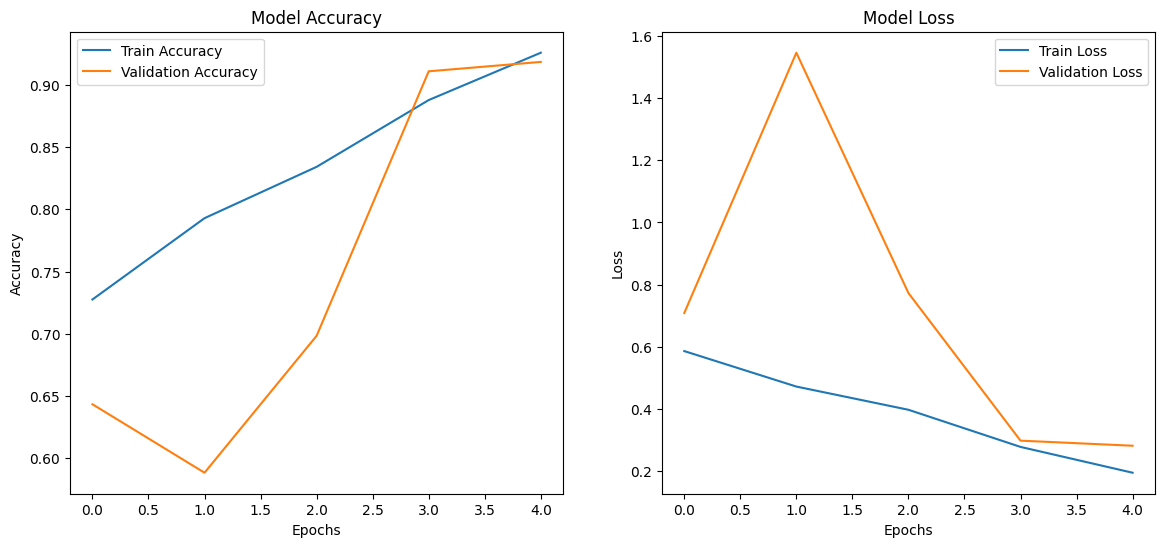

45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step
Classification Report:
              precision    recall  f1-score   support

   Defective       0.94      0.92      0.93       453
          OK       0.86      0.90      0.88       262

    accuracy                           0.91       715
   macro avg       0.90      0.91      0.91       715
weighted avg       0.91      0.91      0.91       715



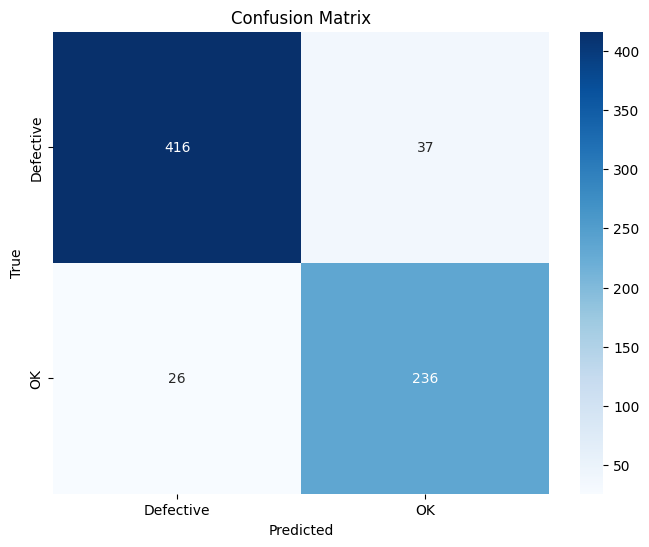

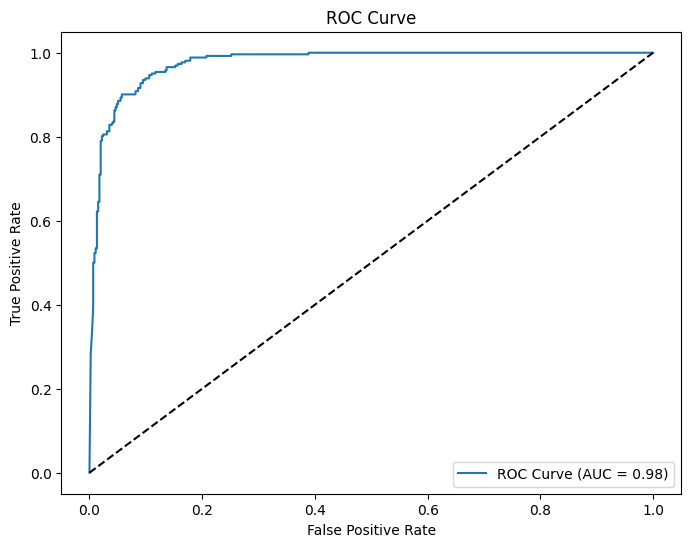


Training DenseNet
Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 104s 251ms/step - accuracy: 0.6247 - loss: 0.7439 - val_accuracy: 0.8816 - val_loss: 0.3157 - learning_rate: 1.0000e-04
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 119s 201ms/step - accuracy: 0.8528 - loss: 0.3407 - val_accuracy: 0.9057 - val_loss: 0.2118 - learning_rate: 1.0000e-04
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 81s 198ms/step - accuracy: 0.9030 - loss: 0.2298 - val_accuracy: 0.9404 - val_loss: 0.1519 - learning_rate: 1.0000e-04
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 89s 220ms/step - accuracy: 0.9243 - loss: 0.1860 - val_accuracy: 0.9668 - val_loss: 0.1033 - learning_rate: 1.0000e-04
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.9346 - loss: 0.1697 - val_accuracy: 0.9585 - val_loss: 0.1234 - learning_rate: 1.0000e-04

Evaluating DenseNet:


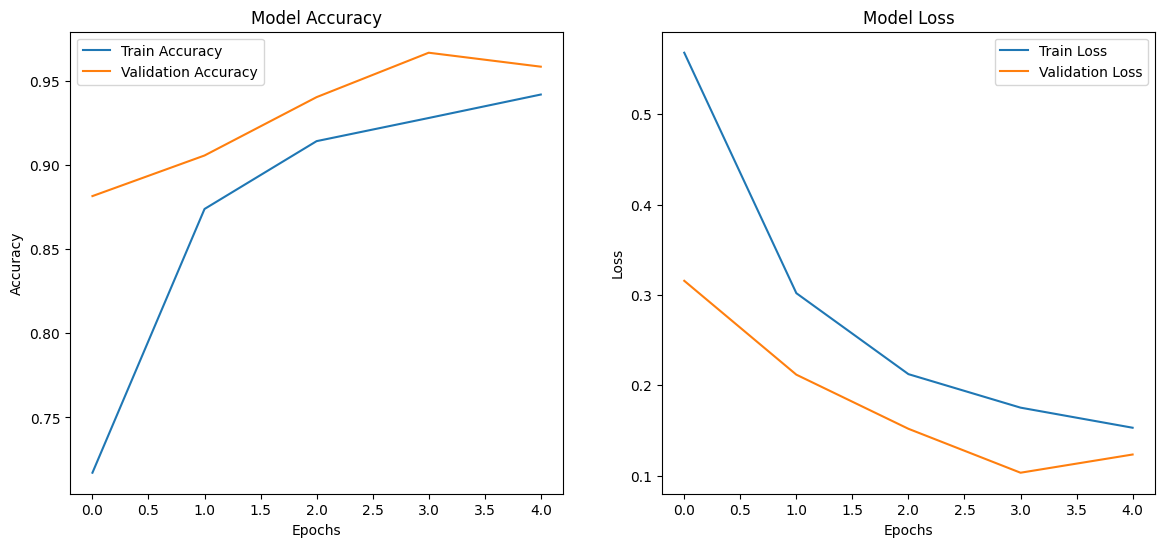

45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step
Classification Report:
              precision    recall  f1-score   support

   Defective       1.00      0.90      0.95       453
          OK       0.85      1.00      0.92       262

    accuracy                           0.94       715
   macro avg       0.93      0.95      0.93       715
weighted avg       0.95      0.94      0.94       715



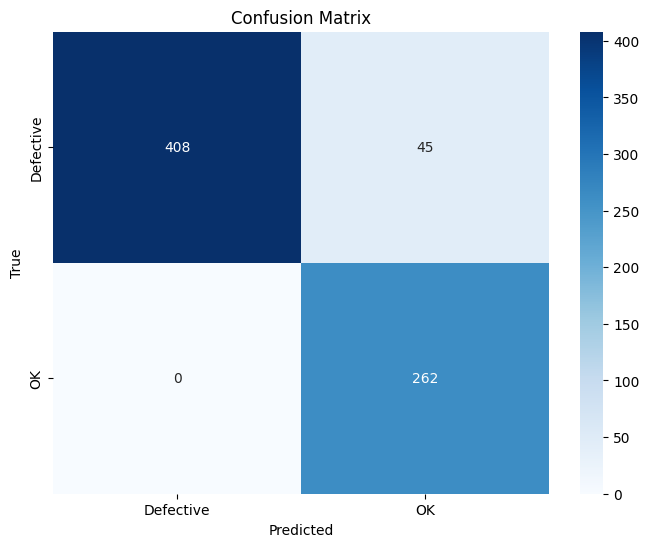

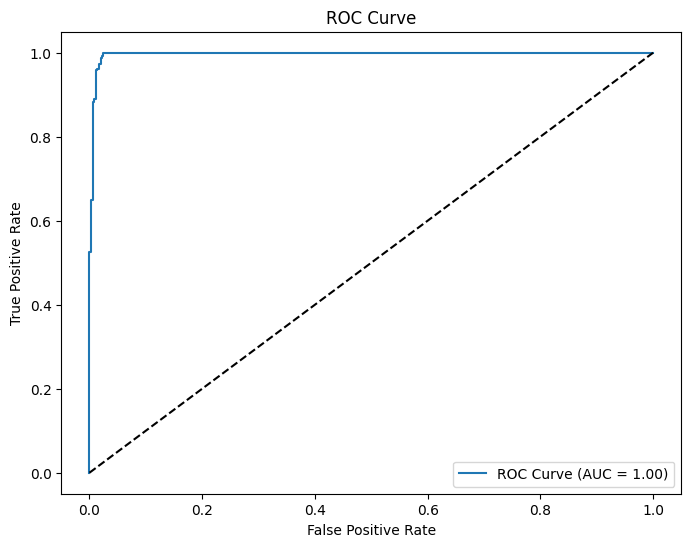


Training Xception
Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 83s 223ms/step - accuracy: 0.6383 - loss: 0.6087 - val_accuracy: 0.5520 - val_loss: 1.0426 - learning_rate: 1.0000e-04
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 72s 205ms/step - accuracy: 0.7879 - loss: 0.4566 - val_accuracy: 0.7888 - val_loss: 0.4894 - learning_rate: 1.0000e-04
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 67s 200ms/step - accuracy: 0.7992 - loss: 0.4340 - val_accuracy: 0.7632 - val_loss: 0.5827 - learning_rate: 1.0000e-04
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 89s 223ms/step - accuracy: 0.8191 - loss: 0.3990 - val_accuracy: 0.8454 - val_loss: 0.3470 - learning_rate: 1.0000e-04
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 76s 204ms/step - accuracy: 0.8221 - loss: 0.3833 - val_accuracy: 0.7934 - val_loss: 0.4457 - learning_rate: 1.0000e-04

Evaluating Xception:


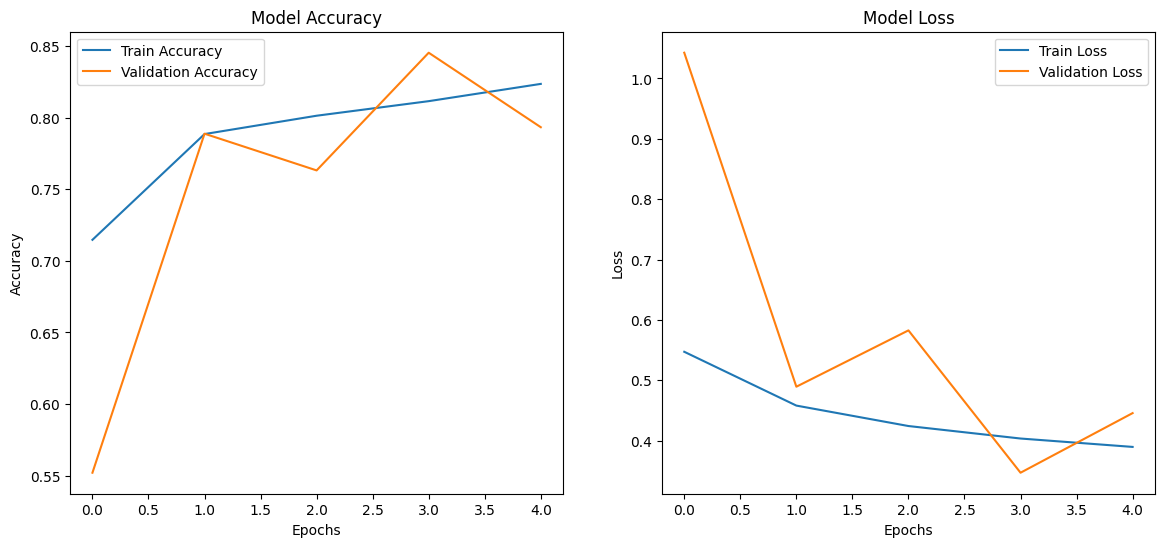

45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step
Classification Report:
              precision    recall  f1-score   support

   Defective       0.87      0.89      0.88       453
          OK       0.81      0.77      0.79       262

    accuracy                           0.85       715
   macro avg       0.84      0.83      0.84       715
weighted avg       0.85      0.85      0.85       715



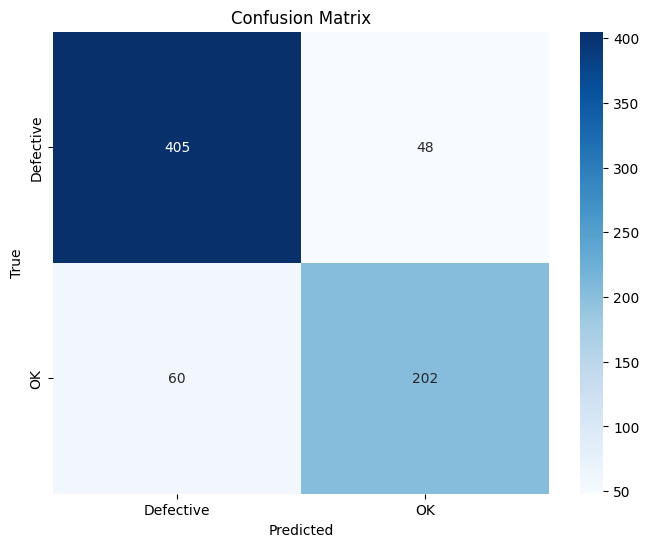

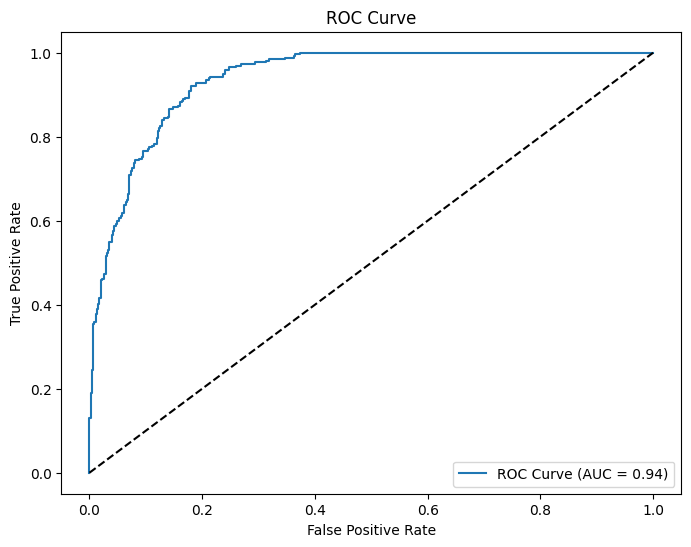

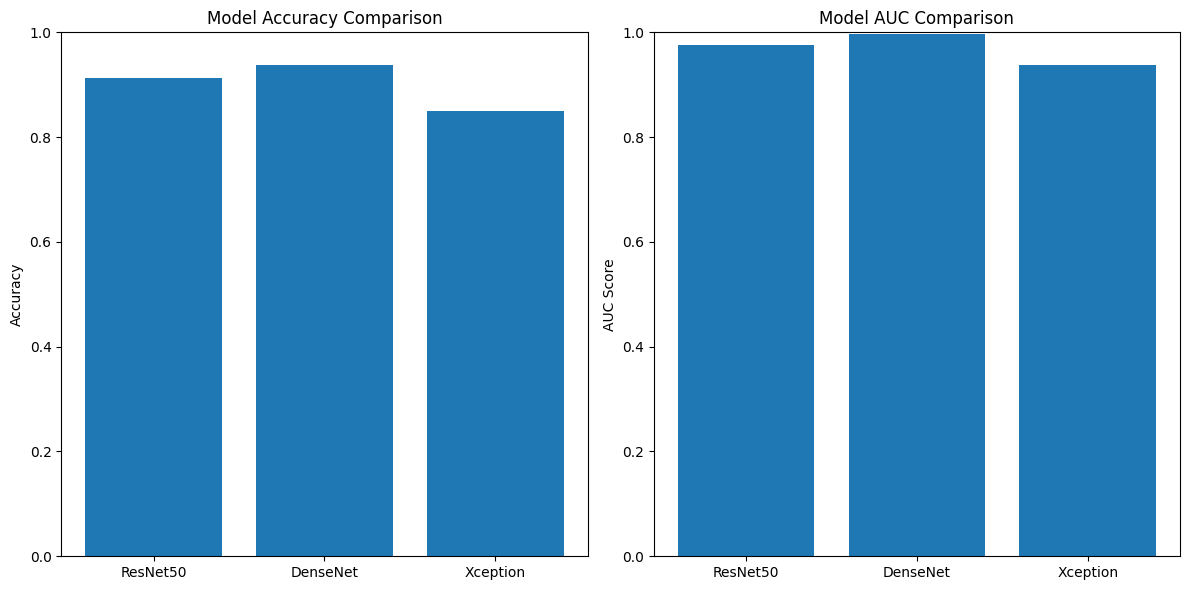


Detailed Model Comparison:

ResNet50:
Final Accuracy: 0.9119
AUC Score: 0.9756
------------------------------

DenseNet:
Final Accuracy: 0.9371
AUC Score: 0.9965
------------------------------

Xception:
Final Accuracy: 0.8490
AUC Score: 0.9375
------------------------------


In [ ]:
def plot_models_comparison(results):
    """Plot comparison of model performances"""
    model_names = list(results.keys())
    accuracies = [results[model]['evaluation']['accuracy'] for model in model_names]
    auc_scores = [results[model]['evaluation']['auc'] for model in model_names]

    # Plot comparison
    plt.figure(figsize=(12, 6))

    # Accuracy comparison
    plt.subplot(1, 2, 1)
    plt.bar(model_names, accuracies)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # AUC comparison
    plt.subplot(1, 2, 2)
    plt.bar(model_names, auc_scores)
    plt.title('Model AUC Comparison')
    plt.ylabel('AUC Score')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()


def main():
    # Create models
    models = {
        'ResNet50': ResNet50(num_classes=2),
        'DenseNet': create_pretrained_model(DenseNet121),
        'Xception': create_pretrained_model(Xception)
    }

    # Create data generators
    train_generator, validation_generator, test_generator = create_data_generators(None)  # No preprocessing for ResNet

    # Train and compare models
    results = compare_models(models, train_generator, validation_generator, test_generator)

    # Plot comparison
    plot_models_comparison(results)

    # Print detailed results
    print("\nDetailed Model Comparison:")
    print("="*50)
    for model_name, model_results in results.items():
        print(f"\n{model_name}:")
        print(f"Final Accuracy: {model_results['evaluation']['accuracy']:.4f}")
        print(f"AUC Score: {model_results['evaluation']['auc']:.4f}")
        print("-"*30)

if __name__ == "__main__":
    main()